In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import pickle
import scanpy as sc
import anndata as ad
import random


import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import matplotlib.colors
from plotnine import *
from plotnine3d import *
import seaborn as sns

import pymannkendall as mk

In [3]:
def get_labels(adata):
    br=[]
    for i in adata.obs["BRAAK"]:
        if i =="Braak 0":
            br.append(0)            
        if i =="Braak I":
            br.append(1)
        elif i =="Braak II":
            br.append(2)
        elif i =="Braak III":
            br.append(3)       
        elif i =="Braak IV":
            br.append(4)
        elif i =="Braak V":
            br.append(5)
        elif i =="Braak VI":
            br.append(6)

    ce=[]
    for i in adata.obs["CERAD"]:
        if i == "Absent":
            ce.append(1)
        elif i=="Sparse":
            ce.append(2)
        elif i=="Moderate":
            ce.append(3)
        elif i=="Frequent":
            ce.append(4)

    co=[]
    for i in adata.obs["Cogdx"]:
        if i=="Control":
            co.append(0)
        elif i=="Dementia":
            co.append(2)
        elif i=="MCI":
            co.append(1)
        else:
            co.append(i)
            
    th=[]
    for i in adata.obs["Thal"]:
        if i =="Thal 0":
            th.append(0)            
        if i =="Thal 1":
            th.append(1)
        elif i =="Thal 2":
            th.append(2)
        elif i =="Thal 3":
            th.append(3)       
        elif i =="Thal 4":
            th.append(4)
        elif i =="Thal 5":
            th.append(5)

            
            
    return br,ce,co,th

def plot_grouped_bar(df,x="braak",y="dpt_pseudotime",text=None,title=None,
                     save=None,xtitle="pseudotime",ytitle="percent of individuals",
                    x_coord=1.5):
    p=(
        ggplot(df, aes(f"{x}",f"{y}"))
        + geom_boxplot( aes(weight=2), fatten=1, width=0.5, fill="lightyellow")#colour="#1F3552", )#fill="#4271AE") +
        + theme_bw() 
        + theme(

            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_line(colour="#d3d3d3"),
            #panel_grid_minor=element_line(colour="#fe4e4e"),
            axis_text_x=element_text(colour="black", size=11,angle = 0,),
            axis_text_y=element_text(colour="black", size=11),
             text=element_text(size=11),
             legend_position="bottom",
             legend_title=element_blank(),
            plot_title=element_text(size=11,ha="center"),
            plot_subtitle = element_text(size = 9, ha="center"),
             figure_size=(2.5,2.5),
         )
        + xlab(f"{xtitle}")
        + ylab(f"{ytitle}")
     
      + geom_smooth(aes(group=1), method = "lm", color="black", linetype="dashed", size=0.5)
      + labs(title=f"{title}")  
      + annotate("text", x=x_coord, y = 1, label=f"{text}", size=9)
          )
    if save:
        p.save(f'{save}', dpi=300)
    print (p)
    
def plot_scatter(df, title,save=None,text1=None, text2=None, 
                 xtitle="pseudotime",ytitle="percent of individuals",
                span=0.1):
    p=(
        ggplot(df,aes(x="dpt_pseudotime",y="cps")) +
        geom_point() +
        geom_smooth(span=span, se=False) +
        theme_bw() +
         theme(
            panel_grid_major=element_blank(),#element_line(colour="#d3d3d3"),
            panel_grid_minor=element_line(colour="#d3d3d3"),
            axis_text_x=element_text(colour="black", size=11,angle = 0,),
            axis_text_y=element_text(colour="black", size=11),
             text=element_text(size=11),
             legend_position="bottom",
             legend_title=element_blank(),
             plot_title = element_text(hjust = 0.5,size=9,),
             plot_subtitle = element_text(size = 9, ha="center",hjust = 0.5,),
             figure_size=(2.5,2.5),
         )
        + xlab(f"{xtitle}")
        + ylab(f"{ytitle}")
        +ggtitle(f'{title}',)
       + annotate("text", x=0.25, y = 0.85, label=f"r={text1},\np={text2}", size=10)
          )
    if save:
        p.save(f'{save}', dpi=300)
    print (p)

### Extended Figure 2a

In [4]:
adata = ad.read_h5ad("./Extended_Figure2_data/SEA-AD_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 80 × 128
    obs: 'AD', 'BRAAK', 'Thal', 'Cogdx', 'CERAD', 'louvain', 'braak', 'dpt_pseudotime'
    var: 'dim'
    uns: 'braak_colors', 'diffmap_evals', 'iroot', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_diffmap', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [15]:
with plt.rc_context(): 
    sc.pl.umap(adata, color=['dpt_pseudotime'], 
           show=False, frameon=False, color_map="Greens")

### Extended Figure 2c,d,e

In [6]:
df=adata.obs[['braak','dpt_pseudotime','BRAAK','Cogdx','CERAD','Thal']]

br,ce,co,th=get_labels(adata)

df["braak"] = pd.Categorical(df['braak'], categories=["Early","Mid","Late"])
df["BRAAK"] = pd.Categorical(df['BRAAK'], categories=['Braak 0', 'Braak I','Braak II', 'Braak III', 'Braak IV', 'Braak V', 'Braak VI'])
df["CERAD"] = pd.Categorical(df['CERAD'], categories=['Absent',  'Sparse','Moderate', 'Frequent'])
df["Cogdx"] = pd.Categorical(df['Cogdx'], categories=['Control', 'MCI','Dementia' ])
df["Thal"] = pd.Categorical(df['Thal'], categories=['Thal 0', 'Thal 1', 'Thal 2', 'Thal 3', 'Thal 4', 'Thal 5'])
df["BRAAK_num"] = pd.Categorical(br, categories=[0,1,2,3,4,5,6 ])
df["CERAD_num"]= pd.Categorical(ce, categories=[1,2,3,4 ])
df["Cogdx_num"]= pd.Categorical(co, categories=[0,1,2])
df["Thal_num"] = pd.Categorical(th, categories=[0,1,2,3,4,5])
names={1:"No\nAD",2:"Poss\nible",3:"Pro\nbable",4:"AD"}
df["CERAD"]=df["CERAD_num"].map(names)

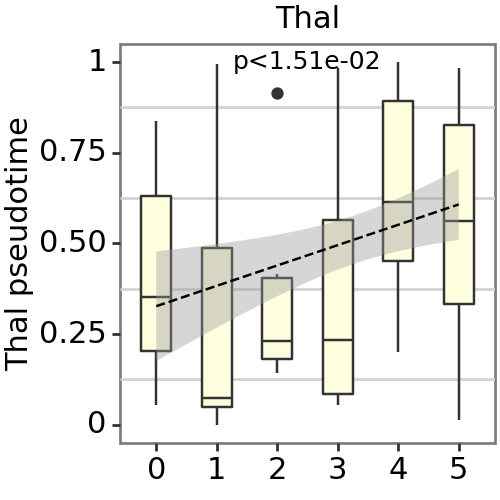

In [7]:
df=df.sort_values(by=["Thal_num"],ascending=True)
result = mk.original_test(df["dpt_pseudotime"].values)

if result.p==0:
    text=f"p=0.0"
else:
    text="p<{:.2e}".format(result.p)
plot_grouped_bar(df,x="Thal_num", text=text,
                 title="Thal",
                 x_coord=3.5,
                 #save="./Extended_Figure2_data/Thal.png",
                 xtitle="",ytitle="Thal pseudotime")

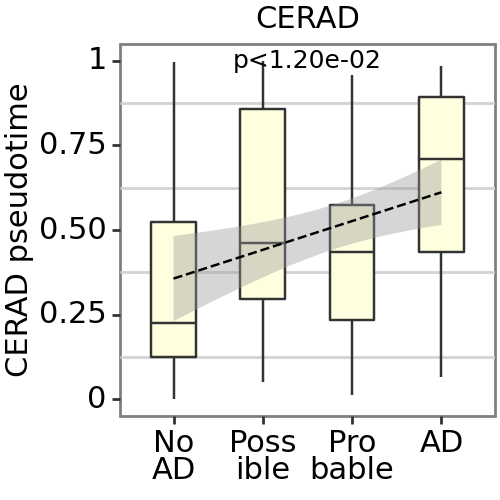

In [8]:
df=df.sort_values(by=["CERAD_num"],ascending=True)
result = mk.original_test(df["dpt_pseudotime"].values)

if result.p==0:
    text=f"p=0.0"
else:
    text="p<{:.2e}".format(result.p)
plot_grouped_bar(df,x="CERAD", text=text,
                 title="CERAD",
                 x_coord=2.5,
                 #save="./Extended_Figure2_data/CERAD.png",
                 xtitle="",ytitle="CERAD pseudotime")

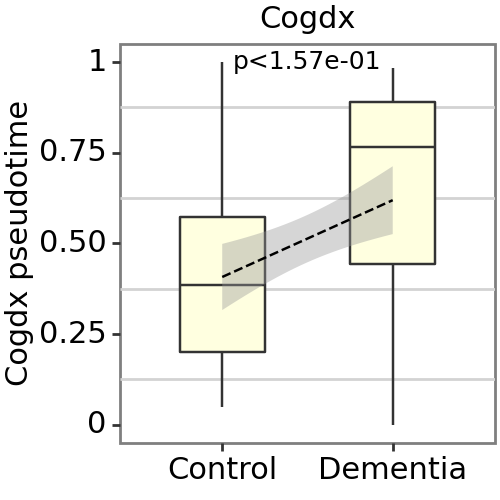

In [9]:
df=df.sort_values(by=["Cogdx_num"],ascending=True)
result = mk.original_test(df["dpt_pseudotime"].values)

if result.p==0:
    text=f"p=0.0"
else:
    text="p<{:.2e}".format(result.p)
plot_grouped_bar(df,x="Cogdx", text=text,
                 title="Cogdx",
                 x_coord=1.5,
                 #save="./Extended_Figure2_data/Cogdx.png",
                 xtitle="",ytitle="Cogdx pseudotime")

### Extended Figure 2b

In [10]:
sample_ids=adata.obs.index
metadata = pd.read_csv("./Extended_Figure2_data/phen_SEA_AD.csv", index_col="Donor ID")
metadata = metadata.loc[sample_ids]

In [11]:
suppl=pd.read_excel("./Extended_Figure2_data/sea_Ad_metadata_suppl_file1.xlsx", index_col="Donor ID")
suppl=suppl.loc[sample_ids]
cps=suppl["Continuous Pseudo-progression Score (CPS)"].values

In [12]:
sample_ids_ad = metadata[metadata["AD"]==1].index

In [14]:
df1=pd.DataFrame()
arr=[]

df1["dpt_pseudotime"]=adata.obs["dpt_pseudotime"].to_list()
df1["cps"]=cps
df1=df1.sort_values(by=['dpt_pseudotime'])
df1.index=sample_ids
df1=df1.loc[sample_ids_ad]

tt=stats.ttest_ind(a=df1["dpt_pseudotime"].to_list(),b=df1["cps"].to_list())

r=stats.pearsonr(df1["dpt_pseudotime"],df1["cps"])
#r=stats.spearmanr(df1["dpt_pseudotime"].to_list(),df1["cps"].to_list())
corr,pval=r
corr=round(corr,2)

plot_scatter(df1, title="",xtitle="pseudotime",ytitle="continuous pseudo-\nprogression score", 
             text1=corr, #text1="{:.2e}".format(corr),
         text2="{:.2e}".format(pval), span=0.9,
             #save="./Extended_Figure2_data/pseudotime_vs_cps.png"
            )